# NYC MTA analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from pandas.tseries.offsets import * # in addition to usual imports

## Pandas Settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.precision', 3)

## Read in data

In [3]:
def read_mta(start_date_str, end_date_str):
    """
    Takes a start date and an end date--which need to be in '%y%m%d' format AND must be found on this
    page: http://web.mta.info/developers/turnstile.html. All files between and including these dates
    are then put into a DataFrame, which is returned.
    """
    temp_date = pd.to_datetime(start_date_str, yearfirst=True)
    end_date = pd.to_datetime(end_date_str, yearfirst=True)
    
    frames = []
    while temp_date <= end_date:    
        dt_string = str(temp_date)
        date_string = dt_string[2:4] + dt_string[5:7] + dt_string[8:10]
        url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(date_string)
        print(url)
    
        frames.append(pd.read_csv(url))
    
        temp_date = temp_date + DateOffset(days=7)
    
    df = pd.concat(frames)
    return df

In [4]:
df = read_mta('171028','180113')
df.head(2)

http://web.mta.info/developers/data/nyct/turnstile/turnstile_171028.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171104.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171111.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171118.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171125.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171202.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171209.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171216.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171223.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_171230.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180106.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180113.txt


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/21/2017,00:00:00,REGULAR,6374009,2156730
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/21/2017,04:00:00,REGULAR,6374037,2156734


## Fix column titles

In [44]:
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,weekday,entries,exits,totals
29539,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,00:00:00,REGULAR,12838398,14275986,2017-10-23 00:00:00,Mon,NaN,NaN,NaN
29540,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,04:00:00,REGULAR,12838432,14276076,2017-10-23 04:00:00,Mon,34.0,90.0,124.0
29541,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,08:00:00,REGULAR,12838726,14276915,2017-10-23 08:00:00,Mon,294.0,839.0,1133.0
29542,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,12:00:00,REGULAR,12839662,14278217,2017-10-23 12:00:00,Mon,936.0,1302.0,2238.0
29543,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,16:00:00,REGULAR,12840496,14279060,2017-10-23 16:00:00,Mon,834.0,843.0,1677.0


In [5]:
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

## Create datetime and weekdays columns. Change DF to weekdays only

In [6]:
df["DateTime"] = pd.to_datetime(df["DATE"]+" "+df["TIME"],format="%m/%d/%Y %H:%M:%S")

In [7]:
df['weekday'] = df['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date().weekday())

In [8]:
def weekday(day_int):
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day = days[day_int]
    return day
df['weekday'] = [weekday(day) for day in df['weekday']]

In [9]:
df = df[(df['weekday']!='Sat') & (df['weekday']!='Sun')]
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,weekday
12,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2017,00:00:00,REGULAR,6375437,2157165,2017-10-23 00:00:00,Mon
13,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2017,04:00:00,REGULAR,6375452,2157165,2017-10-23 04:00:00,Mon


## Entries Exits and Cleaning

In [10]:
# better not to do this as a function?
def net_movement(df, orig_column, new_column):
    """creates a column that shows difference between rows in another column
    also removes negatives
    """
    df[new_column] = df[orig_column].diff()
    mask = ((df['SCP'] != df['SCP'].shift(1)) | 
        (df['STATION'] != df['STATION'].shift(1)) | 
        (df['C/A']!=df['C/A'].shift(1)) | 
        (df['UNIT']!=df['UNIT'].shift(1)) | 
        (df['DATE'] != df['DATE'].shift(1)))
    # following line is giving SettingWithCopyWarning, but works as intended...
    # chain indexing (ie. df[][]) not recommend, but couldn't get .loc to work
    df[new_column][mask] = np.nan
    
    return df

In [11]:
df.sort_values(['STATION','C/A','UNIT','SCP','DateTime'],inplace=True)
df = net_movement(df,'ENTRIES','entries')
df = net_movement(df,'EXITS','exits')
df.head()

/Users/djurk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,weekday,entries,exits
29539,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,00:00:00,REGULAR,12838398,14275986,2017-10-23 00:00:00,Mon,NaN,NaN
29540,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,04:00:00,REGULAR,12838432,14276076,2017-10-23 04:00:00,Mon,34.0,90.0
29541,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,08:00:00,REGULAR,12838726,14276915,2017-10-23 08:00:00,Mon,294.0,839.0
29542,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,12:00:00,REGULAR,12839662,14278217,2017-10-23 12:00:00,Mon,936.0,1302.0
29543,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,16:00:00,REGULAR,12840496,14279060,2017-10-23 16:00:00,Mon,834.0,843.0


In [12]:
def clean(num):
    """when applied to a series replaces negative values and values larger than 10,000 w/ NaN"""
    if (num > 10000) or (num < 0):
        return np.nan
    else:
        return num

df['entries'] = [clean(i) for i in df['entries']]
df['exits'] = [clean(i) for i in df['exits']]

In [13]:
df['totals'] = df['entries'] + df['exits']
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,weekday,entries,exits,totals
29539,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,00:00:00,REGULAR,12838398,14275986,2017-10-23 00:00:00,Mon,NaN,NaN,NaN
29540,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,04:00:00,REGULAR,12838432,14276076,2017-10-23 04:00:00,Mon,34.0,90.0,124.0


## Getting time specific data

In [14]:
def station_mean(df):
    
    """Takes an MTA DataFrame and finds the daily means for each station"""
    
    dfstationsum = df.groupby(['STATION','DATE'],as_index=False).sum()
    dfstationmean = dfstationsum.groupby('STATION',as_index=False).mean()
    
    return dfstationmean

## Breakfast Data

In [15]:
# creates a subset of the original DF w/ only certain times represented
dfbreakfast = df[(df['TIME'] == '11:00:00') | (df['TIME'] == '12:00:00')]
dfbreakfast.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,weekday,entries,exits,totals
29542,H007,R248,00-00-00,1 AV,L,BMT,10/23/2017,12:00:00,REGULAR,12839662,14278217,2017-10-23 12:00:00,Mon,936.0,1302.0,2238.0
29548,H007,R248,00-00-00,1 AV,L,BMT,10/24/2017,12:00:00,REGULAR,12843352,14282796,2017-10-24 12:00:00,Tue,1137.0,1360.0,2497.0


In [16]:
dfstationmeanbreak = station_mean(dfbreakfast)
dfstationmeanbreak.head(2)

,STATION,ENTRIES,EXITS,entries,exits,totals
0,1 AV,3.042e+09,1.642e+09,4594.733,6066.467,10661.2
1,103 ST,1.467e+08,5.952e+08,8620.100,4071.600,12691.7


In [17]:
dfstationmeanbreak[['STATION','totals']].nlargest(10, ['totals'])

,STATION,totals
223,GRD CNTRL-42 ST,70367.233
57,34 ST-PENN STA,58183.533
55,34 ST-HERALD SQ,49984.583
43,23 ST,43829.767
328,TIMES SQ-42 ST,42392.817
14,14 ST-UNION SQ,40729.960
103,86 ST,37614.017
67,47-50 STS ROCK,36109.083
78,59 ST,31655.200
79,59 ST COLUMBUS,29769.717


## Dinner Data

In [18]:
dfdinner = df[(df['TIME'] == '19:00:00') | (df['TIME'] == '20:00:00')]

dfstationmeandinner = station_mean(dfdinner)

In [19]:
dfstationmeandinner[['STATION','totals']].nlargest(10, ['totals'])

,STATION,totals
223,GRD CNTRL-42 ST,88271.450
55,34 ST-HERALD SQ,76228.800
57,34 ST-PENN STA,74471.183
14,14 ST-UNION SQ,62814.040
328,TIMES SQ-42 ST,61758.517
43,23 ST,61058.567
103,86 ST,46434.467
67,47-50 STS ROCK,44817.050
79,59 ST COLUMBUS,42496.733
78,59 ST,39207.233


## Lunch Data

In [20]:
dflunch = df[(df['TIME'] == '15:00:00') | (df['TIME'] == '16:00:00')]

dfstationmeanlunch = station_mean(dflunch)

In [21]:
dfstationmeanlunch[['STATION','totals']].nlargest(10, ['totals'])

,STATION,totals
223,GRD CNTRL-42 ST,44721.917
14,14 ST-UNION SQ,43829.760
55,34 ST-HERALD SQ,39729.317
43,23 ST,36250.133
57,34 ST-PENN STA,35761.417
327,TIMES SQ-42 ST,31924.250
103,86 ST,30078.983
79,59 ST COLUMBUS,26507.517
165,CANAL ST,23803.567
9,125 ST,23703.650


In [22]:
dfbrexits = dfstationmeanbreak[['exits','STATION']]
dfbrexits.nlargest(10, ['exits'])

,exits,STATION
223,44054.200,GRD CNTRL-42 ST
55,33563.017,34 ST-HERALD SQ
67,33489.550,47-50 STS ROCK
328,31401.333,TIMES SQ-42 ST
43,27517.250,23 ST
14,27143.100,14 ST-UNION SQ
57,23265.050,34 ST-PENN STA
254,21312.417,LEXINGTON AV/53
78,20923.017,59 ST
79,20599.817,59 ST COLUMBUS


In [23]:
dflunchbreak = pd.merge(dfstationmeanlunch[['STATION','totals']], dfbrexits, on='STATION')
dflunchbreak.columns = ['STATION','lunch_totals', 'breakfast_exits']
dflunchbreak.head(2)

,STATION,lunch_totals,breakfast_exits
0,1 AV,7464.75,6066.467
1,103 ST,11165.84,4071.600


In [24]:
dflunchbreak['totals_and_exits'] = dflunchbreak['lunch_totals'] + dflunchbreak['breakfast_exits']
dflunchbreak[['STATION','totals_and_exits']].nlargest(10,['totals_and_exits'])

,STATION,totals_and_exits
223,GRD CNTRL-42 ST,88776.117
55,34 ST-HERALD SQ,73292.333
14,14 ST-UNION SQ,70972.860
43,23 ST,63767.383
327,TIMES SQ-42 ST,63325.583
57,34 ST-PENN STA,59026.467
67,47-50 STS ROCK,54453.100
79,59 ST COLUMBUS,47107.333
103,86 ST,45893.517
78,59 ST,43925.083


## Information for Figures

In [25]:
breakfast = dfstationmeanbreak[['STATION','totals']].nlargest(10, ['totals'])
breakfast.columns = ['STATION','breakfast']

lunch = dflunchbreak[['STATION','totals_and_exits']].nlargest(10,['totals_and_exits'])
lunch.columns = ['STATION','lunch + brexits']

dinner = dfstationmeandinner[['STATION','totals']].nlargest(10, ['totals'])
dinner.columns = ['STATION','dinner']

In [26]:
breakfastlunch = pd.merge(breakfast, lunch, on='STATION')
breakfastlunchdinner = pd.merge(breakfastlunch, dinner, on='STATION')
breakfastlunchdinner

,STATION,breakfast,lunch + brexits,dinner
0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450
1,34 ST-PENN STA,58183.533,59026.467,74471.183
2,34 ST-HERALD SQ,49984.583,73292.333,76228.800
3,23 ST,43829.767,63767.383,61058.567
4,TIMES SQ-42 ST,42392.817,63325.583,61758.517
5,14 ST-UNION SQ,40729.960,70972.860,62814.040
6,86 ST,37614.017,45893.517,46434.467
7,47-50 STS ROCK,36109.083,54453.100,44817.050
8,59 ST,31655.200,43925.083,39207.233
9,59 ST COLUMBUS,29769.717,47107.333,42496.733


In [27]:
breakfastlunchdinner.sort_values(['lunch + brexits'], ascending=False)

,STATION,breakfast,lunch + brexits,dinner
0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450
2,34 ST-HERALD SQ,49984.583,73292.333,76228.800
5,14 ST-UNION SQ,40729.960,70972.860,62814.040
3,23 ST,43829.767,63767.383,61058.567
4,TIMES SQ-42 ST,42392.817,63325.583,61758.517
1,34 ST-PENN STA,58183.533,59026.467,74471.183
7,47-50 STS ROCK,36109.083,54453.100,44817.050
9,59 ST COLUMBUS,29769.717,47107.333,42496.733
6,86 ST,37614.017,45893.517,46434.467
8,59 ST,31655.200,43925.083,39207.233


In [28]:
breakfastlunchdinner.sort_values(['dinner'], ascending=False)

,STATION,breakfast,lunch + brexits,dinner
0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450
2,34 ST-HERALD SQ,49984.583,73292.333,76228.800
1,34 ST-PENN STA,58183.533,59026.467,74471.183
5,14 ST-UNION SQ,40729.960,70972.860,62814.040
4,TIMES SQ-42 ST,42392.817,63325.583,61758.517
3,23 ST,43829.767,63767.383,61058.567
6,86 ST,37614.017,45893.517,46434.467
7,47-50 STS ROCK,36109.083,54453.100,44817.050
9,59 ST COLUMBUS,29769.717,47107.333,42496.733
8,59 ST,31655.200,43925.083,39207.233


In [29]:
breakfastlunchdinner

,STATION,breakfast,lunch + brexits,dinner
0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450
1,34 ST-PENN STA,58183.533,59026.467,74471.183
2,34 ST-HERALD SQ,49984.583,73292.333,76228.800
3,23 ST,43829.767,63767.383,61058.567
4,TIMES SQ-42 ST,42392.817,63325.583,61758.517
5,14 ST-UNION SQ,40729.960,70972.860,62814.040
6,86 ST,37614.017,45893.517,46434.467
7,47-50 STS ROCK,36109.083,54453.100,44817.050
8,59 ST,31655.200,43925.083,39207.233
9,59 ST COLUMBUS,29769.717,47107.333,42496.733


In [30]:
breakfastlunchdinner['totals'] = (breakfastlunchdinner['breakfast'] + 
                                  breakfastlunchdinner['lunch + brexits'] + 
                                  breakfastlunchdinner['dinner'])
breakfastlunchdinner.sort_values('totals',ascending=False, inplace=True)
breakfastlunchdinner.reset_index()

,index,STATION,breakfast,lunch + brexits,dinner,totals
0,0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450,247414.800
1,2,34 ST-HERALD SQ,49984.583,73292.333,76228.800,199505.717
2,1,34 ST-PENN STA,58183.533,59026.467,74471.183,191681.183
3,5,14 ST-UNION SQ,40729.960,70972.860,62814.040,174516.860
4,3,23 ST,43829.767,63767.383,61058.567,168655.717
5,4,TIMES SQ-42 ST,42392.817,63325.583,61758.517,167476.917
6,7,47-50 STS ROCK,36109.083,54453.100,44817.050,135379.233
7,6,86 ST,37614.017,45893.517,46434.467,129942.000
8,9,59 ST COLUMBUS,29769.717,47107.333,42496.733,119373.783
9,8,59 ST,31655.200,43925.083,39207.233,114787.517


In [31]:
import seaborn as sns
sns.set()
sns.set_style('dark')

/Users/djurk/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


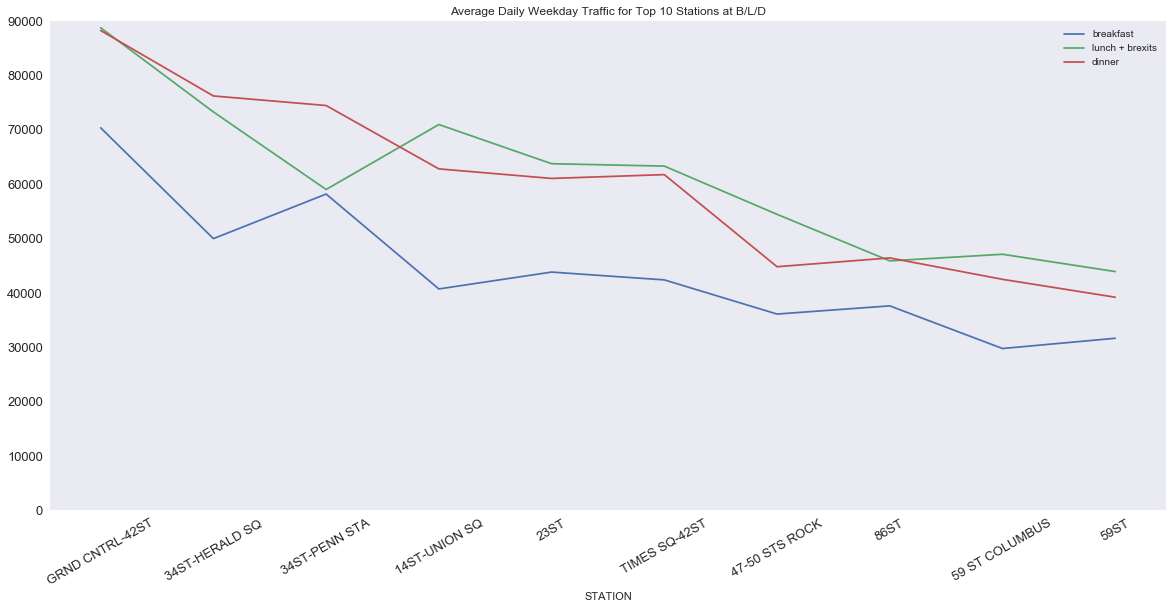

In [32]:
breakfastlunchdinner.plot(x="STATION", y=["breakfast", "lunch + brexits", "dinner"],
                          figsize = (20,9), kind="line", rot = 30, fontsize=13, ylim = (0,90000), 
                          title="Average Daily Weekday Traffic for Top 10 Stations at B/L/D");
plt.xticks([0, 1, 2, 3,4, 5, 6, 7, 8, 9], ['GRND CNTRL-42ST', '34ST-HERALD SQ', '34ST-PENN STA', '14ST-UNION SQ', '23ST', 'TIMES SQ-42ST', '47-50 STS ROCK','86ST', '59 ST COLUMBUS','59ST', ]);





/Users/djurk/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


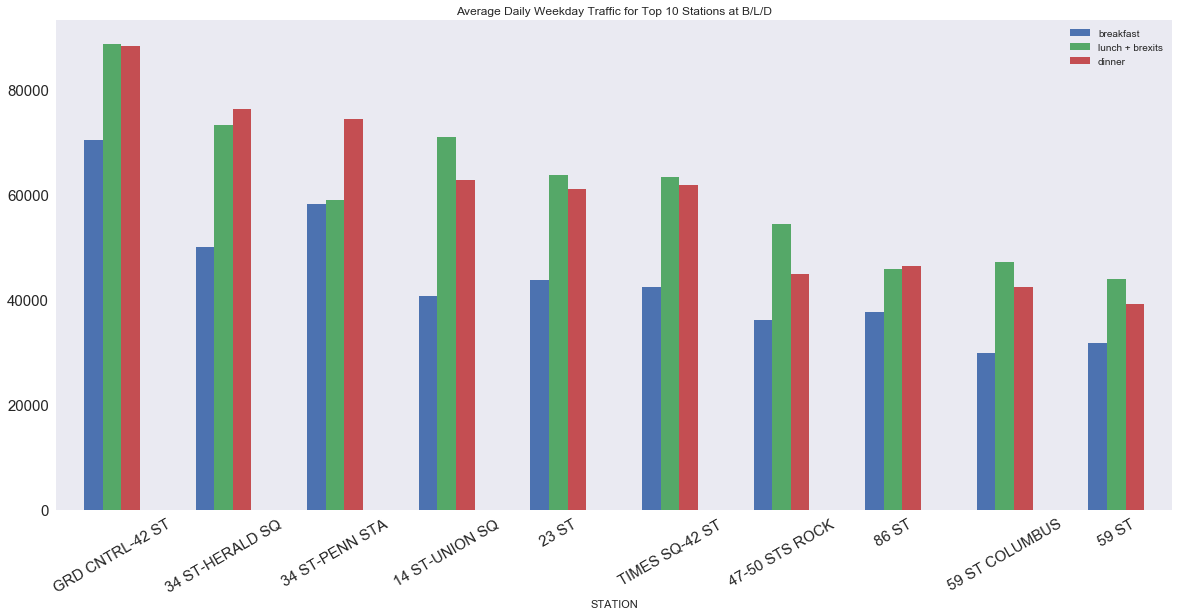

In [33]:
breakfastlunchdinner.plot(x="STATION", y=["breakfast", "lunch + brexits", "dinner"], figsize = (20,9), kind="bar", rot=30, fontsize=15, title="Average Daily Weekday Traffic for Top 10 Stations at B/L/D");

## Sales Estimates

In [34]:
# Assuming 0.2% of people that pass buy a crepe
# Column "day_sales" in units 'Number of crepes sold per day in that location'
for i, row in breakfastlunchdinner.iterrows():
    breakfastlunchdinner.loc[i, 'day_sales'] = sum(row[1:]) * .002 

breakfastlunchdinner

,STATION,breakfast,lunch + brexits,dinner,totals,day_sales
0,GRD CNTRL-42 ST,70367.233,88776.117,88271.450,247414.800,989.659
2,34 ST-HERALD SQ,49984.583,73292.333,76228.800,199505.717,798.023
1,34 ST-PENN STA,58183.533,59026.467,74471.183,191681.183,766.725
5,14 ST-UNION SQ,40729.960,70972.860,62814.040,174516.860,698.067
3,23 ST,43829.767,63767.383,61058.567,168655.717,674.623
4,TIMES SQ-42 ST,42392.817,63325.583,61758.517,167476.917,669.908
7,47-50 STS ROCK,36109.083,54453.100,44817.050,135379.233,541.517
6,86 ST,37614.017,45893.517,46434.467,129942.000,519.768
9,59 ST COLUMBUS,29769.717,47107.333,42496.733,119373.783,477.495
8,59 ST,31655.200,43925.083,39207.233,114787.517,459.150


In [35]:
# adjust sales for time lost from travel between locations.  Travel time estimated from google maps.
def sale_lost(count, minutes):
    crepe_per_min = count // (4 * 60) * 0.002
    crepes_lost = crepe_per_min * minutes
    return crepes_lost

In [36]:
# 34 ST-PENN STA -> 23 ST -> 34 ST-PENN STA
# Without time lost to travel

move_34p23s34p = (breakfastlunchdinner.iloc[1, 1]
               + breakfastlunchdinner.iloc[3, 2]
               + breakfastlunchdinner.iloc[1, 3]) * 0.002
move_34p23s34p

394.3724866666667

In [37]:
# 34 ST-PENN STA -> 23 ST @ 11:30 am = 20 min
move_1_23st = sale_lost(breakfastlunchdinner.iloc[1, 1], 20)

# 23 ST -> 34 ST-PENN STA @ 3:30 pm = 20 min
move_2_23st = sale_lost(breakfastlunchdinner.iloc[3, 2], 20)

# Print total crepe sales lost due to transit
adjustment_1 = move_1_23st + move_2_23st
print('Adjusted total for route: ' + str(move_34p23s34p - adjustment_1))

Adjusted total for route: 374.252486667


In [38]:
# 34 ST-PENN STA -> 14 ST-UNION SQ -> 34 ST-PENN STA
# Without time lost to travel

move_34p14u34p = (breakfastlunchdinner.iloc[1, 1]
               + breakfastlunchdinner.iloc[5, 2]
               + breakfastlunchdinner.iloc[1, 3]) * 0.002
move_34p14u34p

379.07793333333336

In [39]:
# 34 ST-PENN STA -> 14 ST-UNION SQ @ 11:30 am = 30 min
move_1_union = sale_lost(breakfastlunchdinner.iloc[1, 1], 30)

# 14 ST-UNION SQ -> 34 ST-PENN STA @ 3:30 pm = 30 min
move_2_union = sale_lost(breakfastlunchdinner.iloc[5, 2], 30)

# Print total crepe sales lost due to transit
adjustment_2 = move_1_union + move_2_union
print('Adjusted total for route: ' + str(move_34p14u34p - adjustment_2))

Adjusted total for route: 350.817933333


In [40]:
# 34 ST-PENN STA -> 34 ST-HERALD SQ -> 34 ST-HERALD SQ
# Without time lost to travel

move_34p34h34h = (breakfastlunchdinner.iloc[1, 1]
               + breakfastlunchdinner.iloc[2, 2]
               + breakfastlunchdinner.iloc[2, 3]) * 0.002
move_34p34h34h

366.96446666666668

In [41]:
# 34 ST-PENN STA -> 34 ST-HERALD SQ @ 11:30 am = 10 min
move_1_herald = sale_lost(breakfastlunchdinner.iloc[1, 1], 10)

# Print total crepe sales lost due to transit
print('Adjusted total for route: ' + str(move_34p34h34h - move_1_herald))

Adjusted total for route: 362.804466667


In [42]:
# 23 ST -> 14 ST-UNION SQ -> 14 ST-UNION SQ
# Without time lost to travel

move_34p14u14u = (breakfastlunchdinner.iloc[3, 1]
               + breakfastlunchdinner.iloc[5, 2]
               + breakfastlunchdinner.iloc[5, 3]) * 0.002
move_34p14u14u

331.62812000000002

In [43]:
# 23 ST -> 14 ST-UNION SQ @ 11:30 am = 20 min
move_3_union = sale_lost(breakfastlunchdinner.iloc[3, 1], 20)

# Print total crepe sales lost due to transit
adjustment_2 = move_1_union + move_2_union
print('Adjusted total for route: ' + str(move_34p14u14u - move_3_union))

Adjusted total for route: 324.86812
